<a href="https://colab.research.google.com/github/thshek0/Linear-LMS-estimator/blob/main/Linear_LMS_estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Least Square Estimator (LLMS estimator)

Target: Estimate normal mean  
> Prior: $\Theta\sim Uniform(0, 1)$  
> Data: $X\sim Normal(\Theta, 1)$  

Compare performance of Bayesian estimator (LLMS vs LMS vs MAP estimator)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import scipy.integrate as integrate
from scipy import optimize

LMS estimate = $E[\Theta | X] = \int_{0}^{1} \theta \cdot f(x|\theta)d\theta$ (requires posterior)

LLMS estimate = $\frac{ \frac{E[\Theta]}{Var[\Theta]} + \sum_{i=1}^{n} \frac{x_i}{Var[W_i]} }{\frac{1}{Var[\Theta]} + \sum_{i=1}^{n} \frac{1}{Var[W_i]}} $,   where $W_i = X_i -\Theta$ (all expectations and variances are calculate by hand)

MAP estimate = $argmax_{\theta} f(x|\theta)$ (requires posterior)

Conditional mean-squared error (MSE): $E[(\Theta-\hat{\theta})^2|X=x] = E[\Theta^2|X=x] -2\hat{\theta}E[\Theta|X=x] + \hat{\theta^2}$

In [3]:
class Sample:
    def __init__(self, mean=0.5, sample_size=500):
        self.sample_size = sample_size
        self.mean = mean                                                                    # true mean
        self.sample = self.regen_samples()                                                  # generate n samples from Normal
        self.__post_constant = integrate.quad(self.__temp_posterior, 0, 1, limit=100)[0]    # f(x) in denominator of Bayes' rule
        self.lms = self.lms_estimate()
        self.llms = self.llms_estimate()
        self.map_est = self.map_estimate()

    # generate samples from Normal + update all attributes based on new posterior / samples
    def regen_samples(self):
        self.sample = norm.rvs(size=self.sample_size) + self.mean
        self.__post_constant = integrate.quad(self.__temp_posterior, 0, 1, limit=100)[0]
        self.lms_estimate()
        self.llms_estimate()
        self.map_estimate()
        return self.sample

    # posterior (not yet normalized)
    def __temp_posterior(self, theta):
        return np.prod(norm.pdf(self.sample, loc=theta))

    # normalized posterior by Bayes' rule
    def posterior(self, theta):
        return self.__temp_posterior(theta) / self.__post_constant

    # by conditional expectation calculation
    def lms_estimate(self):
        self.lms = integrate.quad(lambda x: x * self.posterior(x), 0, 1, limit=100)[0]
        return self.lms

    # by formula of llms
    def llms_estimate(self):
        exp_x = 1/2
        var_x = 1/12
        var_w = 11/12
        self.llms = (exp_x / var_x + np.sum(self.sample) / var_w) / (1 / var_x + self.sample_size / var_w)
        return self.llms

    # finding maxima of posterior
    def map_estimate(self):
        self.map_est = optimize.fminbound(lambda x: -self.posterior(x), 0, 1, disp=False)
        return self.map_est

    # equivalent to conditional mse
    def mse(self, theta):
        output1 = integrate.quad(lambda x: x * x * self.posterior(x), 0, 1, limit=100)[0]
        output2 = integrate.quad(lambda x: x * self.posterior(x), 0, 1, limit=100)[0]
        return output1 - 2 * theta * output2 + theta ** 2

In [4]:
temp = Sample(0.5, 500)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


Text(0.5, 1.0, 'Posterior pdf (n=500)')

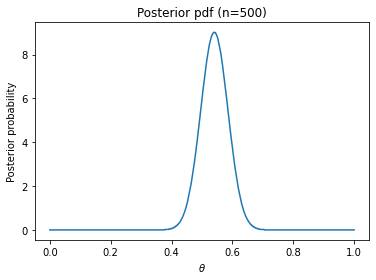

In [5]:
x = np.linspace(0, 1, 1000)
post_pt = np.array([temp.posterior(i) for i in x])

fig, ax = plt.subplots(1, 1)
ax.plot(x, post_pt, label='posterior pdf')
plt.xlabel(r'$\theta$')
plt.ylabel('Posterior probability')
plt.title('Posterior pdf (n=500)')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps

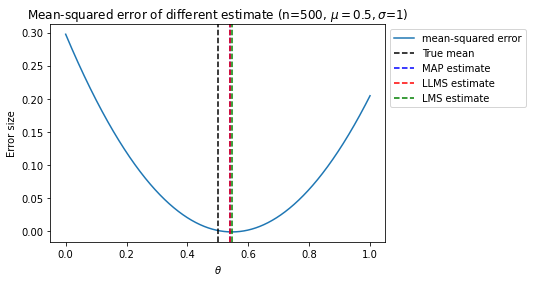

In [69]:
x = np.linspace(0, 1, 1000)
fig, ax = plt.subplots(1, 1)
plt.xlabel(r'$\theta$')
plt.ylabel('Error size')
plt.title('Mean-squared error of different estimate (n=500, $\mu=0.5, \sigma$=1)')
ax.plot(x, temp.mse(x), label='mean-squared error')
plt.axvline(x=temp.mean, color='black', ls='--', label='True mean')
plt.axvline(x=temp.map_est, color='b', ls='--', label='MAP estimate')
plt.axvline(x=temp.llms, color='r', ls='--', label='LLMS estimate')
plt.axvline(x=temp.lms, color='g', ls='--', label='LMS estimate')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
# left = min(true_mean, map_est, llms, lms)
# right = max(true_mean, map_est, llms, lms)

# left = min(map_est, llms, lms)
# right = max(map_est, llms, lms)

# side_interval = (right - left) * 0.1
# plt.xlim(left-side_interval, right+side_interval)

Compare squared-error for different estimator in different true mean

In [70]:
import pandas as pd

df = pd.DataFrame(columns=['Mean', 'LMS', 'LLMS', 'MAP'])
mean = np.linspace(0.1, 0.9, 17)
repeat = 50
for cnt, i in enumerate(mean):
    sim = Sample(i, 200)
    for j in range(repeat):
        df.loc[cnt * repeat + j] = [sim.mean, sim.lms, sim.llms, sim.map_est]
        sim.regen_samples()
df

,Mean,LMS,LLMS,MAP
0,0.1,0.083974,0.082014,0.059025
1,0.1,0.079110,0.073829,0.050389
2,0.1,0.091217,0.093346,0.070980
3,0.1,0.119414,0.130893,0.110591
4,0.1,0.149686,0.164743,0.146304
...,...,...,...,...
845,0.9,0.924999,0.933519,0.957362
846,0.9,0.837616,0.822094,0.839809
847,0.9,0.849406,0.834301,0.852687
848,0.9,0.906391,0.903104,0.925273


In [71]:
df['LMS_se'] = (df['LMS'] - df['Mean'])**2
df['LLMS_se'] = (df['LLMS'] - df['Mean'])**2
df['MAP_se'] = (df['MAP'] - df['Mean'])**2

mean_df = pd.DataFrame(columns=['Mean', 'LMS', 'LLMS', 'MAP', 'LMS_se', 'LLMS_se', 'MAP_se'])
# mean_df.loc[0] = df[df["Mean"] == 0.1].mean()
for cnt, i in enumerate(mean):
    mean_df.loc[cnt] = df[df["Mean"] == i].mean()
mean_df
# df.dtypes

,Mean,LMS,LLMS,MAP,LMS_se,LLMS_se,MAP_se
0,0.10,0.122935,0.128576,0.108148,0.002715,0.003873,0.003468
1,0.15,0.169306,0.180807,0.163252,0.004264,0.005233,0.004943
2,0.20,0.188320,0.200975,0.184529,0.003774,0.003826,0.004497
3,0.25,0.275525,0.287020,0.275306,0.005760,0.005994,0.005786
4,0.30,0.299436,0.309688,0.299221,0.006806,0.006252,0.006855
5,0.35,0.343932,0.352047,0.343909,0.004071,0.003633,0.004076
6,0.40,0.387391,0.393248,0.387376,0.006090,0.005378,0.006095
7,0.45,0.445063,0.447927,0.445062,0.004087,0.003654,0.004087
8,0.50,0.516837,0.515960,0.516837,0.003996,0.003590,0.003996
9,0.55,0.539304,0.537255,0.539304,0.004218,0.003849,0.004218


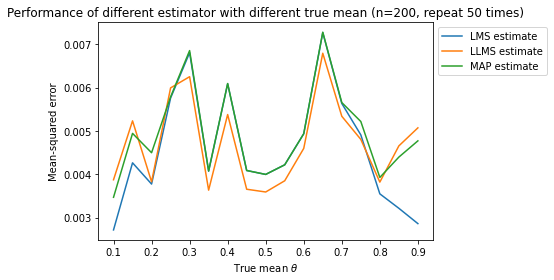

In [72]:
fig, ax = plt.subplots(1, 1)
plt.xlabel(r'True mean $\theta$')
plt.ylabel('Mean-squared error')
plt.title('Performance of different estimator with different true mean (n=200, repeat 50 times)')
ax.plot(mean_df['Mean'], mean_df['LMS_se'], label='LMS estimate')
ax.plot(mean_df['Mean'], mean_df['LLMS_se'], label='LLMS estimate')
ax.plot(mean_df['Mean'], mean_df['MAP_se'], label='MAP estimate')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')